## Agrupación de IPs por sus palabras clave

Paso 1: Cargar el dataset

In [1]:
import pandas as pd

df = pd.read_csv("Keywords/author_keyword_matrix.csv", index_col=0)

# Mostrar resumen
print("✅ Dataset generado con forma:", df.shape)
print("🔢 Palabras clave totales:", len(df.columns))
print("👥 Autores con keywords:", len(df))

✅ Dataset generado con forma: (29, 3329)
🔢 Palabras clave totales: 3329
👥 Autores con keywords: 29


Paso 2: Preprocesamiento (normalización y reducción PCA)

In [2]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

X = df.values
X_normalized = Normalizer().fit_transform(X)

Paso 3: Clustering con Spectral Clustering

In [4]:
# === Configuraciones de preprocesamiento y clustering ===
pca_dims = [2, 5, 10, 20]
k_values = list(range(2, 16))

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluar KMeans para k entre 2 y 15
results = []

# === Estudio con Spectral Clustering ===
for n_dim in pca_dims:
    X_reduced = PCA(n_components=n_dim).fit_transform(X_normalized)

    for k in k_values:
        try:
            model = SpectralClustering(n_clusters=k, assign_labels='kmeans', random_state=42)
            labels = model.fit_predict(X_reduced)

            silhouette = silhouette_score(X_reduced, labels)
            ch_score = calinski_harabasz_score(X_reduced, labels)
            db_score = davies_bouldin_score(X_reduced, labels)

            results.append({
                "PCA_dims": n_dim,
                "k": k,
                "Silhouette": silhouette,
                "Calinski-Harabasz": ch_score,
                "Davies-Bouldin": db_score,
                "Labels": labels
            })

        except Exception as e:
            results.append({
                "PCA_dims": n_dim,
                "k": k,
                "Silhouette": np.nan,
                "Calinski-Harabasz": np.nan,
                "Davies-Bouldin": np.nan,
                "Error": str(e),
                "Labels": []
            })

# === Análisis de resultados ===
df_results = pd.DataFrame(results).dropna(subset=["Silhouette"])
print("✅ Resultados de clustering generados con forma:", df_results.shape)
print("🔍 Resultados de clustering:", df_results.head())

✅ Resultados de clustering generados con forma: (56, 6)
🔍 Resultados de clustering:    PCA_dims  k  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0         2  2    0.472894          25.653950        0.817366   
1         2  3    0.579498          48.101235        0.584834   
2         2  4    0.447776          32.304057        0.697604   
3         2  5    0.565479          48.576285        0.514087   
4         2  6    0.563349          45.761195        0.585624   

                                              Labels  
0  [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...  
1  [1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, ...  
2  [0, 0, 0, 3, 3, 0, 0, 1, 3, 3, 0, 1, 1, 2, 2, ...  
3  [0, 4, 4, 1, 1, 0, 0, 2, 1, 1, 0, 2, 2, 3, 3, ...  
4  [2, 0, 0, 1, 1, 2, 2, 5, 3, 3, 2, 5, 5, 4, 4, ...  


In [8]:
metrics = df_results[["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]].copy()
metrics["Davies-Bouldin"] = -metrics["Davies-Bouldin"]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(metrics), columns=metrics.columns)

df_results["score_combined"] = (
    0.8 * scaled["Silhouette"] +
    0.1 * scaled["Calinski-Harabasz"] +
    0.1 * scaled["Davies-Bouldin"]
)

best_per_k = (
    df_results
    .sort_values("score_combined", ascending=False)
    .drop_duplicates(subset=["k"])
    .sort_values("k")
)

# Mostrar resumen
print("✅ Mejores configuraciones por número de clusters:")
print(best_per_k[["PCA_dims", "k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "score_combined"]])

✅ Mejores configuraciones por número de clusters:
    PCA_dims   k  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0          2   2    0.472894          25.653950        0.817366   
1          2   3    0.579498          48.101235        0.584834   
2          2   4    0.447776          32.304057        0.697604   
3          2   5    0.565479          48.576285        0.514087   
4          2   6    0.563349          45.761195        0.585624   
19         5   7    0.660560          36.368540        0.398946   
20         5   8    0.707194          55.613358        0.347886   
21         5   9    0.667507          71.437051        0.458005   
36        10  10    0.687213          18.587040        0.605766   
37        10  11    0.742427          34.801451        0.387033   
38        10  12    0.700369          38.577030        0.400349   
39        10  13    0.684275          45.803818        0.311503   
40        10  14    0.619119          45.201434        0.332248   
41        10

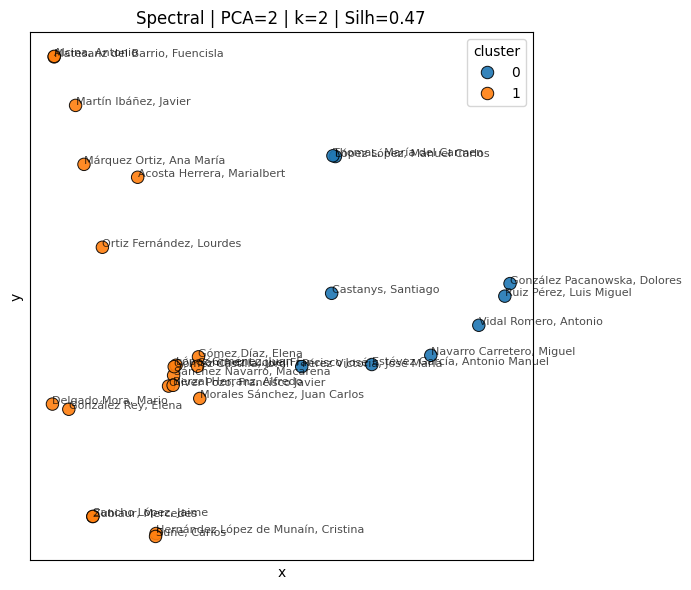

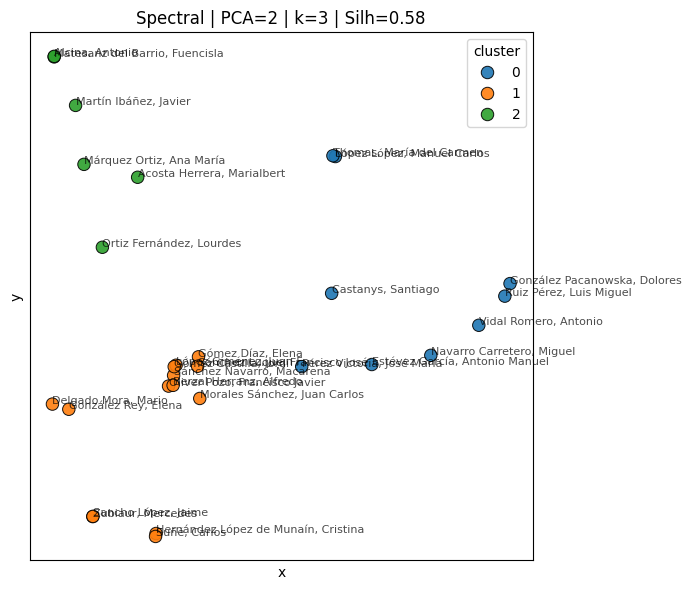

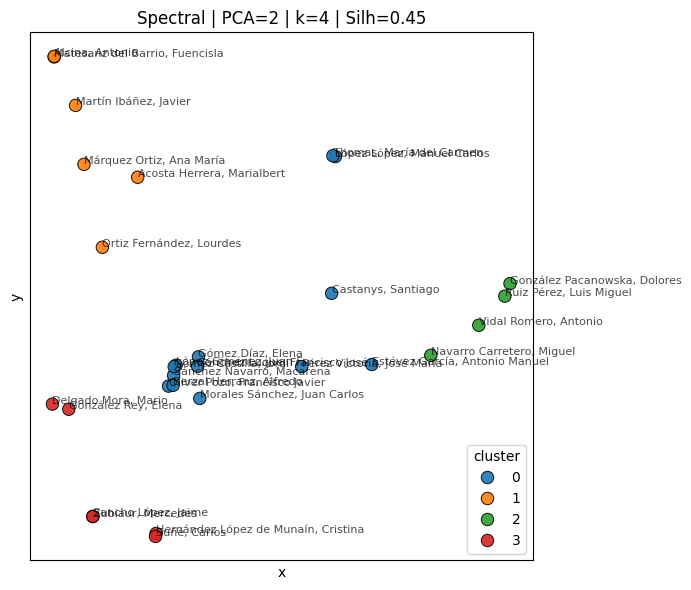

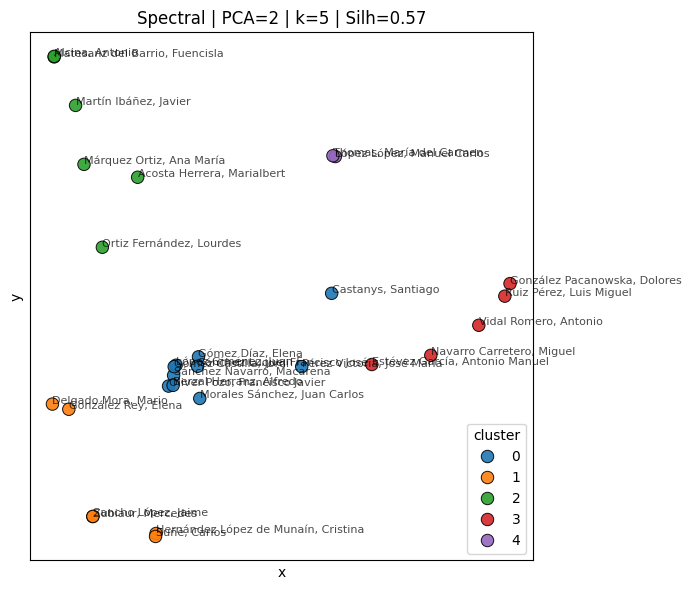

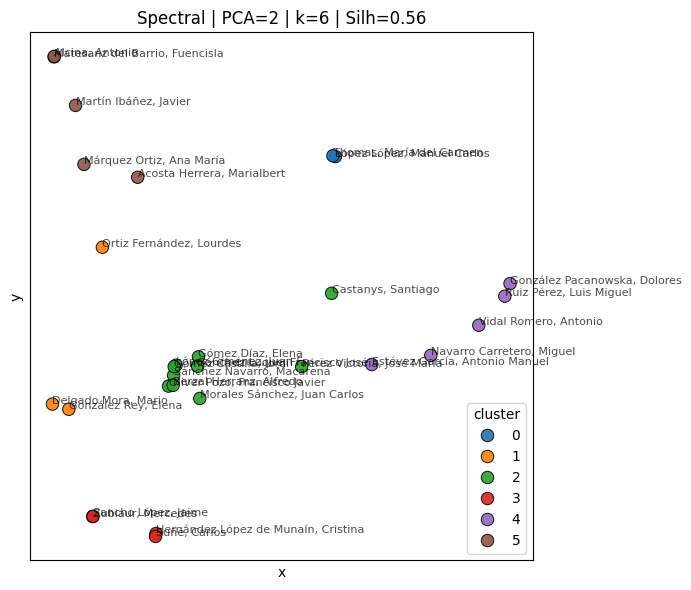

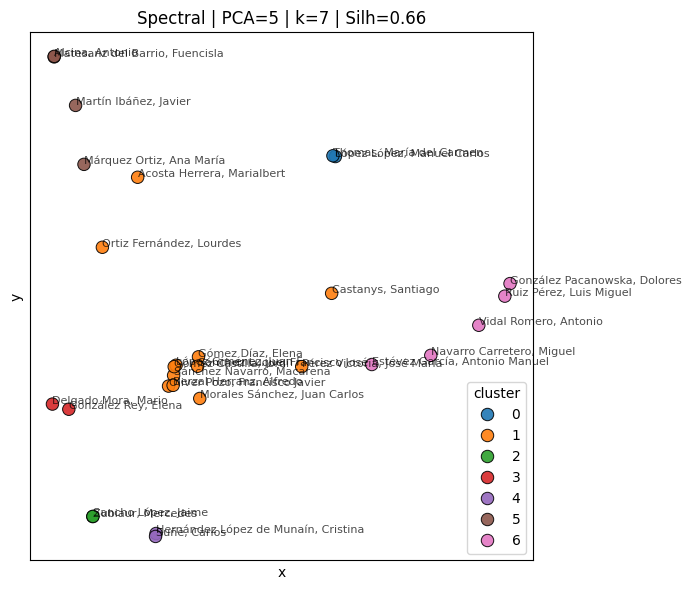

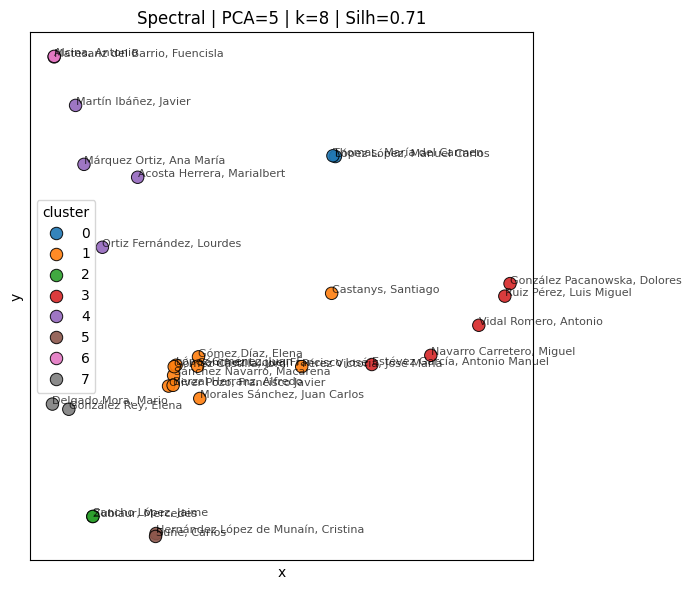

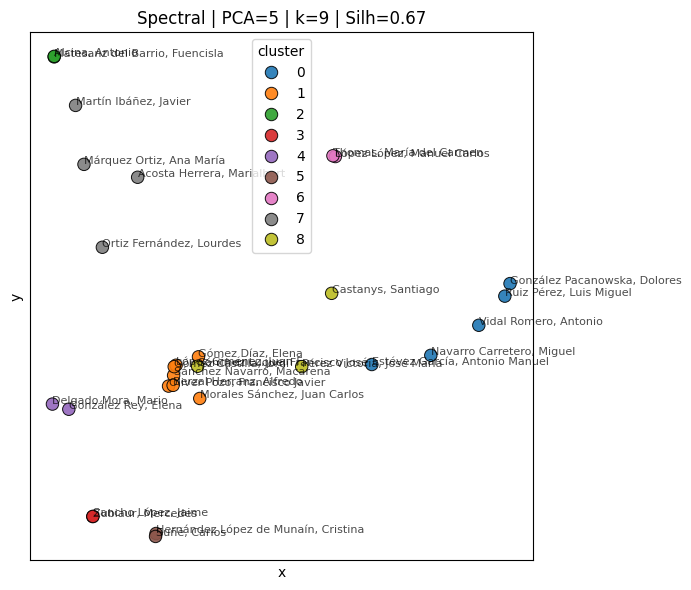

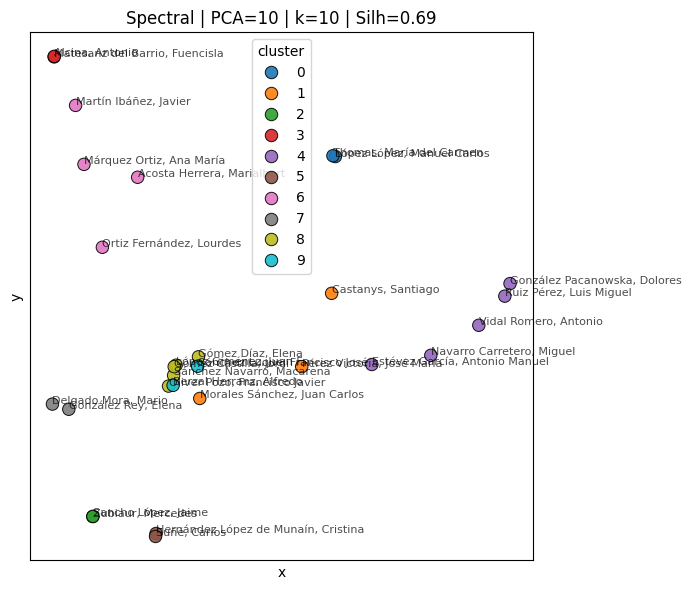

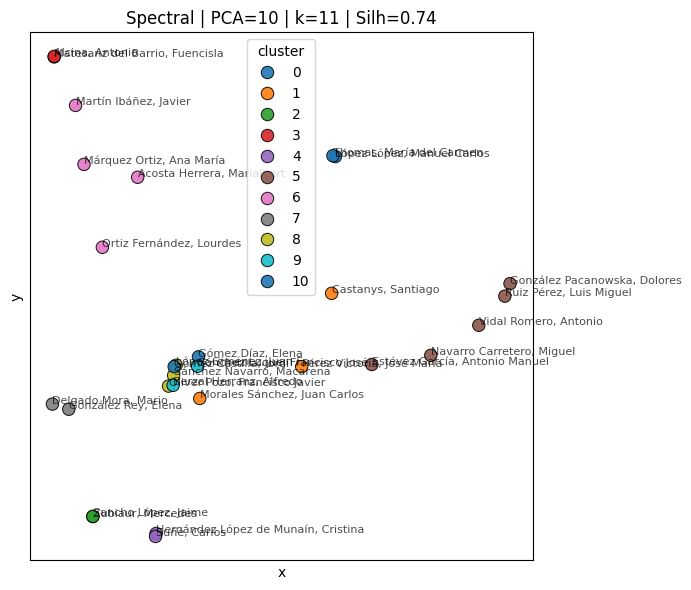

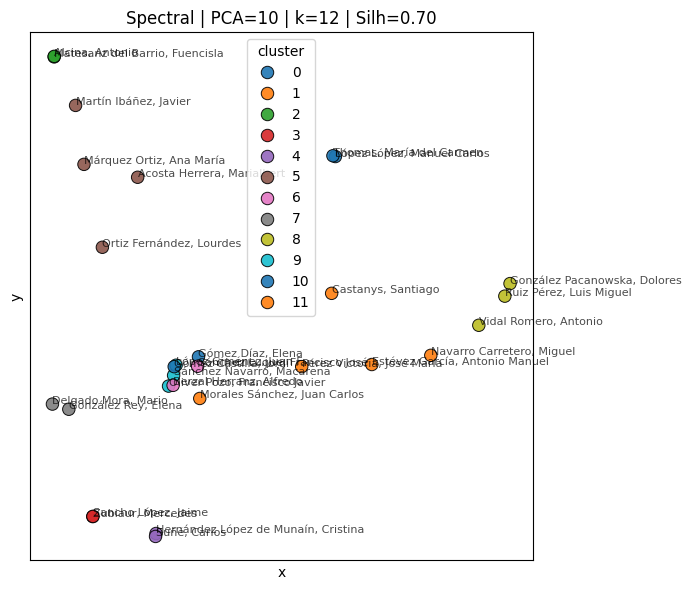

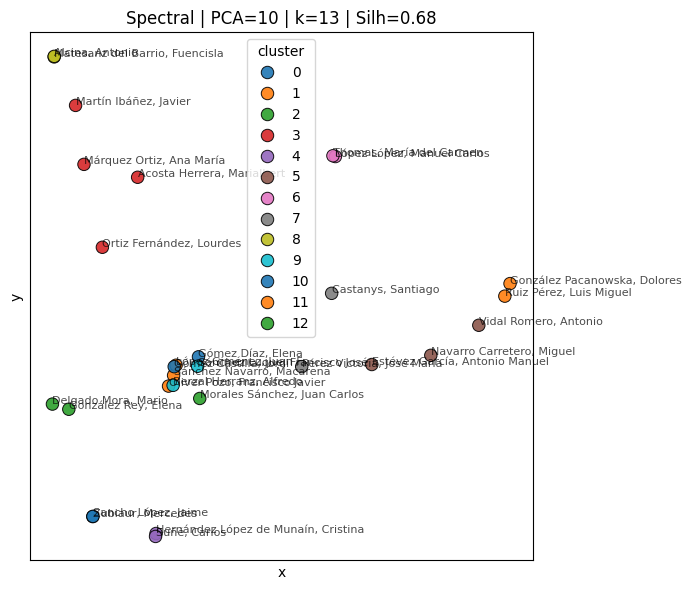

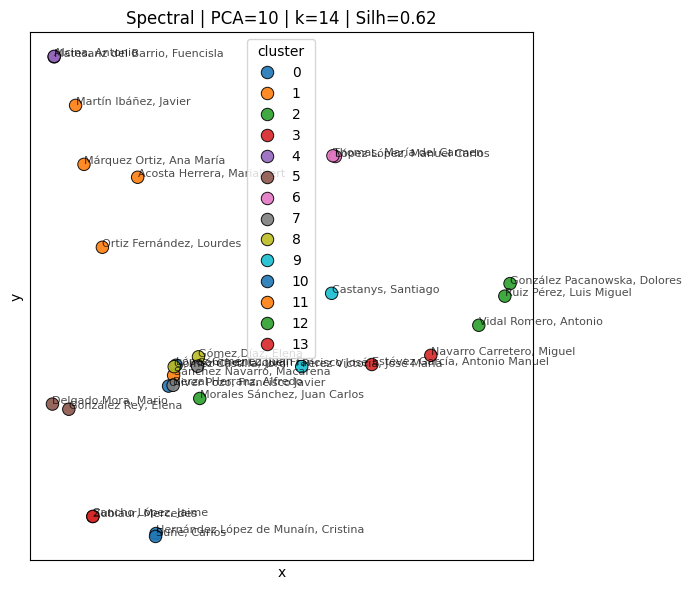

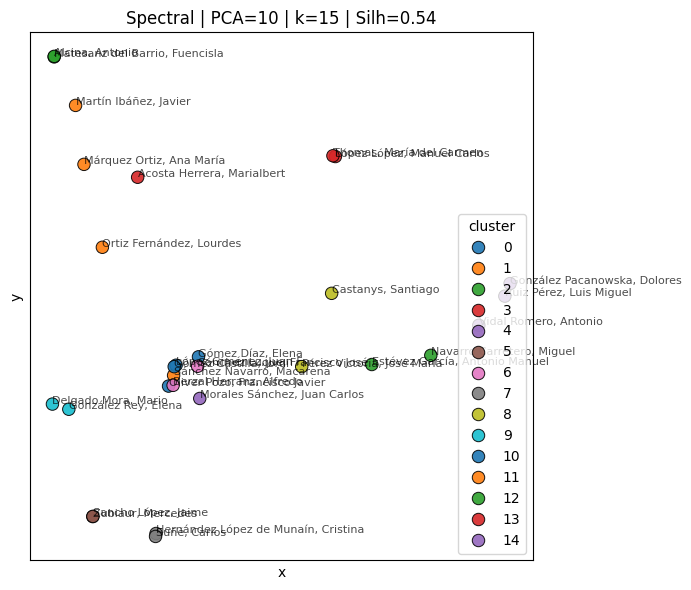

In [9]:
# === Visualización ===
X_2d = PCA(n_components=2).fit_transform(X_normalized)

for _, row in best_per_k.iterrows():
    labels = row["Labels"]
    coords_df = pd.DataFrame(X_2d, columns=["x", "y"])
    coords_df["author"] = df.index
    coords_df["cluster"] = labels

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=coords_df, x="x", y="y", hue="cluster", palette="tab10", s=80, edgecolor='k', alpha=0.9)
    for _, r in coords_df.iterrows():
        plt.text(r["x"], r["y"], r["author"], fontsize=8, alpha=0.7)

    plt.title(f"Spectral | PCA={row['PCA_dims']} | k={row['k']} | Silh={row['Silhouette']:.2f}")
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show()




Guardamos los resultados

In [10]:
# === Guardar resultados ===
cluster_records = []

for _, row in best_per_k.iterrows():
    for author, cluster in zip(df.index, row["Labels"]):
        cluster_records.append({
            "author": author,
            "cluster": int(cluster),
            "k": row["k"],
            "pca_dims": row["PCA_dims"],
            "silhouette": row["Silhouette"],
            "calinski_harabasz": row["Calinski-Harabasz"],
            "davies_bouldin": row["Davies-Bouldin"]
        })

pd.DataFrame(cluster_records).to_csv("Keywords/Spectral/spectral_best_configs.csv", index=False)